# Localization

Use "localization" to learn a Cahn-Hilliard model.


## Learn a Cahn-Hilliard

Square domain periodic boundary conditions

## $$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

## What are we trying to do?

Create a mapping from $t_0$ to $t_{10}$ without doing all the steps. We want to do the following.

## $$ \phi[s](t=t_0) \rightarrow \phi[s](t=t_{10})$$

## Represent $\phi$ as a microstructure function

### $$ \phi_j(\vec{r}) = \int_H h \; m_j(h; \vec{r}) \; dh $$

### $$ \int_H m_j(h; \vec{r}) \; dh = 1 $$

### $$ m_j(h; \vec{r}) = \delta(h - \phi_j(\vec{r})) $$ 

Can think of $\phi_j$ as the expectation of the microstructure function and $m_j$ as a probability density function. In our Cahn-Hilliard, $ -1 < \phi_j[s] < 1 $.

## Represent $\phi$ as a microstructure function (discrete)

### $$ \phi_j [s] = \sum_{h \in H} h \; m_j [ h; s] $$

Now, we define 

### $$ m_j [h; s] = \delta [ h - \phi_j[s] ] $$

where

### $$ \delta [x] = \max \left( 1 - \left|\frac{x}{\Delta h}\right|, 0 \right) $$



[ 0.   0.   0.4  0.6  0. ]


/home/wd15/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


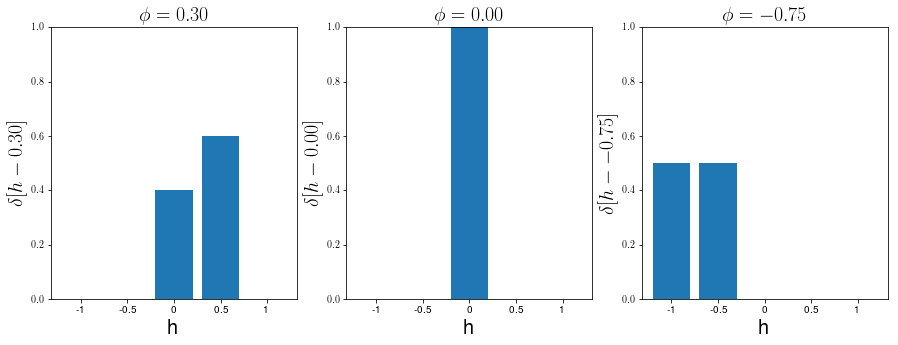

In [1]:
# NBVAL_IGNORE_OUTPUT

%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

def delta_func(x, dh):
    return np.maximum(1 - abs(x) / dh, 0)

hs = np.array([-1., -0.5, 0, 0.5, 1])

phi = 0.3

print(delta_func(hs - phi, 0.5))
f, axs = plt.subplots(1, 3)
f.set_size_inches((15, 5))

for ax, phi in zip(axs, [0.3, 0.0, -0.75]):
    ax.bar(np.arange(len(hs)), delta_func(hs - phi, 0.5))
    ax.set_xticklabels(['', '-1', '-0.5', '0', '0.5', '1'])
    ax.set_ylabel('$\delta[h - {0:.2f}]$'.format(phi), fontsize=20)
    ax.set_xlabel('h', fontsize=20)
    ax.set_ylim([0, 1])
    ax.set_title('$\phi={0:.2f}$'.format(phi), fontsize=20)
f.show()

    

In [2]:
from pymks.bases import PrimitiveBasis
phi = np.array([[0.3]])
print(phi.shape)
print(phi)
basis = PrimitiveBasis(n_states=5, domain=[-1, 1])

basis.discretize(phi)

(1, 1)
[[ 0.3]]


array([[[ 0. ,  0. ,  0.4,  0.6,  0. ]]])

In [3]:
basis.discretize(np.array([[0.0]]))

array([[[ 0.,  0.,  1.,  0.,  0.]]])

In [4]:
basis.discretize(np.array([[-0.75]]))

array([[[ 0.5,  0.5,  0. ,  0. ,  0. ]]])

## Localization

Use regression for each local state.

# $$ p_j[s] = \sum_{r \in S} \sum_{h \in H} \alpha[h; s] m_j[h; s + r] $$

## $$ \phi_j[s](t=t_0) \rightarrow \phi_j[s](t=t_{10})$$

We will do lots of simulations to create the "response", $\phi_j[s](t=t_{10})$ from the "microstructure" (i.e. lots of random initial conditions), $\phi_j[s](t=t_0)$.

## $$ p_j[s] = \phi_j[s](t=t_{10}) $$

## $$ m_j[s; h] = \delta[h - \phi_j[s]] $$

## Create Samples

In [5]:
%matplotlib inline

import pymks
import matplotlib.pyplot as plt
import numpy as np
from pymks.datasets import make_cahn_hilliard

In [266]:
n_steps = 10
size = (151, 151)
X, y = make_cahn_hilliard(n_samples=10, size=size, dt=1., n_steps=n_steps)

In [267]:
print(X.shape)
print(y.shape)

(10, 151, 151)
(10, 151, 151)


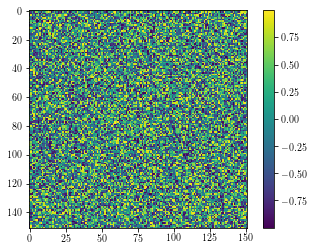

In [338]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(X[0])
plt.colorbar()

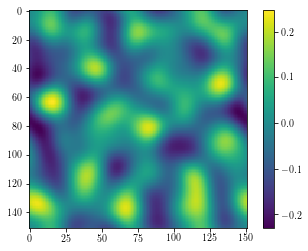

In [339]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y[0])
plt.colorbar()

## Parallel

In [270]:
from dask import compute, delayed
import dask.multiprocessing

def make_data(seed):
    np.random.seed(seed)
    return make_cahn_hilliard(n_samples=10, size=size, dt=1., n_steps=n_steps)

funcs = [delayed(make_data)(seed) for seed in range(30)]
    
out = compute(*funcs, get=dask.multiprocessing.get)


In [271]:
np.array(out).shape

(30, 2, 10, 151, 151)

In [272]:
X = np.array(out)[:, 0].reshape((300,) + size)
y = np.array(out)[:, 1].reshape((300,) + size)

## Learning

In [273]:
from pymks import MKSLocalizationModel
from pymks.bases import PrimitiveBasis

basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)

In [274]:
model.fit(X[:-1], y[:-1])

In [275]:
y_pred = model.predict(X[-1:])

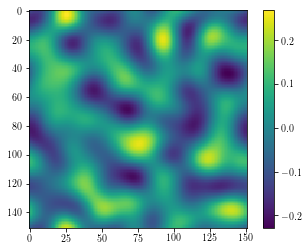

In [340]:
# NBVAL_IGNORE_OUTPUT
plt.imshow(y_pred[0])
plt.colorbar()

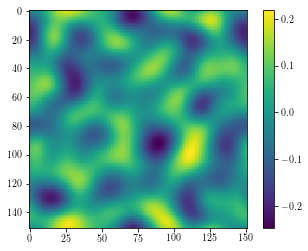

In [341]:
# NBVAL_IGNORE_OUTPUT
plt.imshow(y[-1])
plt.colorbar()

## Train Test Split

In [342]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [343]:
basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)

In [344]:
model.fit(X_train, y_train)

In [345]:
y_pred = model.predict(X_test)

In [346]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y_pred.flatten(), y_test.flatten())

2.0855855798715083e-06

In [347]:
# NBVAL_IGNORE_OUTPUT

print(y_pred[0][0][:10])
print(y_test[0][0][:10])

[ 0.05078787  0.05908873  0.06639798  0.07267825  0.07792362  0.08215174
  0.08539685  0.08770398  0.08912465  0.0897139 ]
[ 0.05325513  0.06165035  0.06901828  0.07532427  0.08056613  0.08476595
  0.08796273  0.09020636  0.091553    0.09206198]


In [348]:
y_pred.shape

(75, 151, 151)

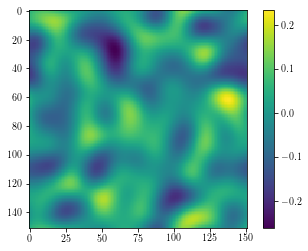

In [351]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_pred[0])
plt.colorbar()

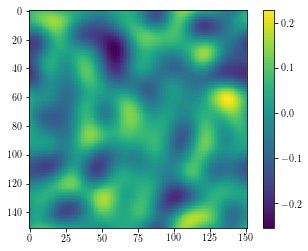

In [352]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_test[0])
plt.colorbar()

## Scale Up

In [311]:
X_big, y_big = make_cahn_hilliard(n_samples=1, size=(1000, 1000), dt=1., n_steps=n_steps)

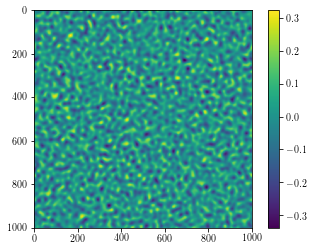

In [312]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_big[0])
plt.colorbar()

In [313]:
basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)
model.fit(X, y)
model.resize_coeff(y_big[0].shape)

In [314]:
y_big_pred = model.predict(X_big)

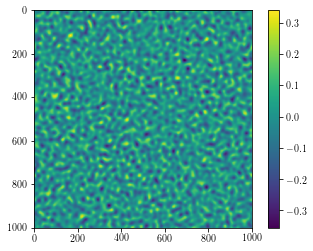

In [315]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_big_pred[0])
plt.colorbar()

In [316]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y_big_pred.flatten(), y_big.flatten())

1.9588557819685957e-06

In [317]:
# NBVAL_IGNORE_OUTPUT

%timeit make_cahn_hilliard(n_samples=1, size=(1000, 1000), dt=1., n_steps=n_steps)

1 loop, best of 3: 2.33 s per loop


In [318]:
# NBVAL_IGNORE_OUTPUT

%timeit model.predict(X_big)

1 loop, best of 3: 211 ms per loop


## Multiple Steps

In [353]:
X2, y2 = make_cahn_hilliard(n_samples=1, size=size, dt=1., n_steps=2 * n_steps)

basis = PrimitiveBasis(n_states=10, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)
model.fit(X, y)

In [334]:
tmp = model.predict(X2)
y2_pred = model.predict(tmp)

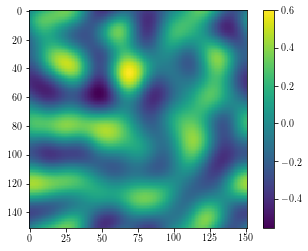

In [335]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y2[0])
plt.colorbar()

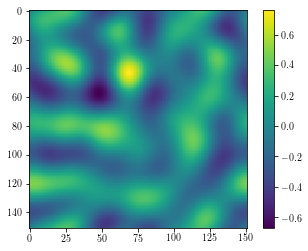

In [336]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y2_pred[0])
plt.colorbar()

In [337]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y2_pred.flatten(), y2.flatten())

0.00031887566310425937

## Cross Validation

In [265]:
from pymks.bases import LegendreBasis
from sklearn.model_selection import GridSearchCV
from dask_searchcv import GridSearchCV
from sklearn import metrics
mse = metrics.mean_squared_error

prim_basis = PrimitiveBasis(2, [-1, 1])
leg_basis = LegendreBasis(2, [-1, 1])

params_to_tune = {'n_states': [2, 3, 5, 8, 13],
                  'basis': [prim_basis, leg_basis]}
model = MKSLocalizationModel(prim_basis)
score_func = metrics.make_scorer(lambda x, y: -mse(x.flatten(), y.flatten()))
gscv = GridSearchCV(model, params_to_tune, cv=5, scoring=score_func)

In [261]:
# NBVAL_SKIP

gscv.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=MKSLocalizationModel(basis=<pymks.bases.primitive.PrimitiveBasis object at 0x7f1ab155eb38>,
           lstsq_rcond=2.2204460492503131e-12, n_jobs=None,
           n_states=array([0, 1])),
       iid=True, n_jobs=-1,
       param_grid={'n_states': [2, 3, 5, 8, 13], 'basis': [<pymks.bases.primitive.PrimitiveBasis object at 0x7f1ab155eb38>, <pymks.bases.legendre.LegendreBasis object at 0x7f1ae322d9b0>]},
       refit=True, return_train_score=True, scheduler=None,
       scoring=make_scorer(<lambda>))

In [262]:
# NBVAL_SKIP

gscv.best_estimator_

MKSLocalizationModel(basis=<pymks.bases.legendre.LegendreBasis object at 0x7f1ab15a99b0>,
           lstsq_rcond=2.2204460492503131e-12, n_jobs=None, n_states=5)

In [263]:
# NBVAL_SKIP

gscv.score(X_test, y_test)

-1.4014279952746725e-05

In [264]:
# NBVAL_SKIP

gscv.cv_results_

{'mean_test_score': array([ -6.23220653e-05,  -6.27468568e-05,  -1.58927676e-05,
         -1.37563961e-05,  -1.39248210e-05,  -6.23220653e-05,
         -6.27552694e-05,  -1.32708789e-05,  -1.34863464e-05,
         -1.39130932e-05]),
 'mean_train_score': array([ -6.16019268e-05,  -6.13050909e-05,  -1.51830687e-05,
         -1.26657607e-05,  -1.20914808e-05,  -6.16019268e-05,
         -6.13116056e-05,  -1.26513233e-05,  -1.24177969e-05,
         -1.20696361e-05]),
 'param_basis': masked_array(data = [<pymks.bases.primitive.PrimitiveBasis object at 0x7f1ab155eb38>
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_n_states': masked_array(data = [2 3 5 8 13 2 3 5 8 13],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'params': [{'basis': <pymks.bases.primitive.PrimitiveBasis at 0x7f1ab155eb38>,
   'n_states': 2},
  {'basis': <pymks.bases.primitive.PrimitiveBasis a